In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import BlackScholes as bs
import time
import variance_curve as vc
import ImpliedDrift as iD

from scipy.optimize import least_squares as ls
from rbergomi import rBergomi
from matplotlib import cm

In [2]:
def price(S, K, r, q, T):
    n = len(K)
    p = np.zeros(n)
    for i in range(n):
        p[i] = np.mean(np.maximum(S-K[i],0)*np.exp(-(r-q)*T))
    return p

In [3]:
spot = np.array(pd.read_csv("spot.csv").Spot)
index = 0
S0 = spot[index]

IV_df = pd.read_csv("hist_spx.csv")
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])
maturities = np.array(IV_df['Exp Date']).flatten()
IV = np.array(IV_df.drop(columns = 'Exp Date'))/100.

K = moneyness*S0/100

In [9]:
start_time_all = time.time()
nr = len(maturities); nc = len(K);
rB_vol = np.zeros([nr,nc]); rB_param = np.zeros([nr,3])
inp = np.array([0.1, 1.9, -0.9]) # Parameter array [H,eta,rho]
bnds = ([.0001, 1, -0.999],[.2, 7, -.8])
N = 25000; n = 1500;
t = np.zeros(nr)

np.random.seed(index)

for i in range(nr):
    
    start_time = time.time()
    
    vol = IV[i]; T = maturities[i];
    
    if T > 0.5:
        N = 20000; n = 1000;
    if T > 1:
        N = 20000; n = 300;
    if T > 3:
        N = 15000; n = 100;
    
    r = iD.r(T, index); q = iD.q(T, index);
    
    def h(x):
        
        np.random.seed(index)

        H, eta, rho = x
        alpha = H - 0.5

        rB = rBergomi(n, N, T, alpha)
        
        xi = vc.variance_curve(rB.t[0], index)
        
        dW1 = rB.dW1(); dW2 = rB.dW2();
        Ya = rB.Y(dW1)
        dZ = rB.dZ(dW1, dW2, rho)
        V = rB.V(Ya, xi, eta)
        S = rB.S(V, dZ, r, q, S0)

        P = price(S, K, r, q, T)
        rB_v = bs.BSImpliedVol(S0, K, T, r, q, P, Option_type = 1, toll = 1e-5)

        return rB_v

    def f(x):
        return h(x) - vol

    result = ls(f, inp, bounds = bnds, max_nfev = 10, ftol = 1e-10, gtol = 1e-10, xtol = 1e-10)
    rB_param[i,:] = result.x
    
    t[i] = time.time() - start_time

    print(f'Iteration: {i}\t Elapsed time: {t[i]: .0f} s')
    
    rB_vol[i,:] = h(result.x)

total_time = (time.time() - start_time_all)/60

print(f'\\nTotal execution time: {total_time: .0f} minutes')

print(f"Relative mean error: {np.mean(abs(IV-rB_vol)/IV)*100:.4f}%")

Iteration: 0	 Elapsed time:  7 s
Iteration: 1	 Elapsed time:  3 s
Iteration: 2	 Elapsed time:  47 s
Iteration: 3	 Elapsed time:  49 s
Iteration: 4	 Elapsed time:  65 s
Iteration: 5	 Elapsed time:  101 s
Iteration: 6	 Elapsed time:  89 s
Iteration: 7	 Elapsed time:  114 s
Iteration: 8	 Elapsed time:  153 s
Iteration: 9	 Elapsed time:  102 s
Iteration: 10	 Elapsed time:  137 s
Iteration: 11	 Elapsed time:  68 s
Iteration: 12	 Elapsed time:  69 s
Iteration: 13	 Elapsed time:  109 s
Iteration: 14	 Elapsed time:  108 s
Iteration: 15	 Elapsed time:  108 s
Iteration: 16	 Elapsed time:  139 s
Iteration: 17	 Elapsed time:  96 s
Iteration: 18	 Elapsed time:  124 s
Iteration: 19	 Elapsed time:  50 s
Iteration: 20	 Elapsed time:  43 s
Iteration: 21	 Elapsed time:  42 s
Iteration: 22	 Elapsed time:  88 s
Iteration: 23	 Elapsed time:  181 s
Iteration: 24	 Elapsed time:  42 s
Iteration: 25	 Elapsed time:  66 s
Iteration: 26	 Elapsed time:  62 s
Iteration: 27	 Elapsed time:  84 s
Iteration: 28	 Elapse

In [11]:
print(f"Relative mean error: {np.mean(abs(IV[2:,:]-rB_vol[2:,:])/IV[2:,:])*100:.4f}%")

Relative mean error: 0.7832%


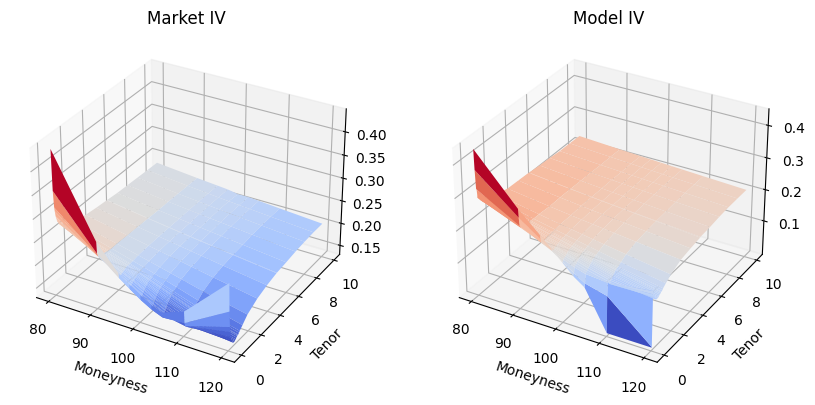

In [14]:
mesh_x, mesh_y = np.meshgrid(moneyness,maturities)

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

ax1 = fig.add_subplot(121,projection='3d')
surf1 = ax1.plot_surface(mesh_x, mesh_y, IV, cmap=cm.coolwarm, antialiased=True)
ax1.set_xlabel('Moneyness')
ax1.set_ylabel('Tenor')
ax1.set_title('Market IV')

ax2 = fig.add_subplot(122,projection='3d')
surf2 = ax2.plot_surface(mesh_x, mesh_y, rB_vol, cmap=cm.coolwarm, antialiased=True)
ax2.set_xlabel('Moneyness')
ax2.set_ylabel('Tenor')
ax2.set_title('Model IV')

plt.show()

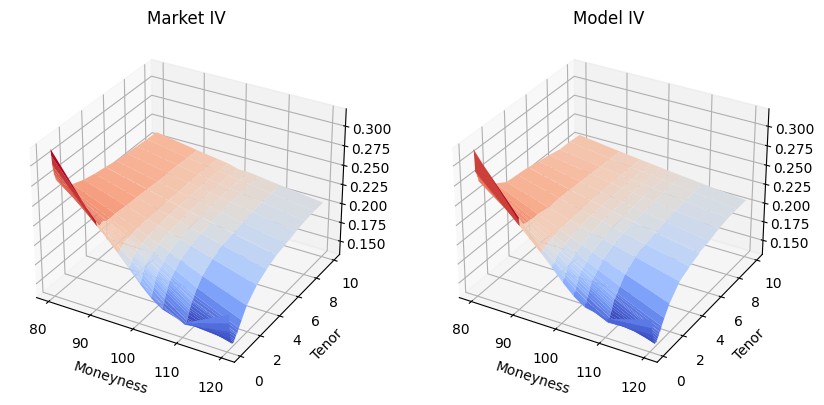

In [21]:
aux = 2

mesh_x, mesh_y = np.meshgrid(moneyness,maturities[aux:])

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

ax1 = fig.add_subplot(121,projection='3d')
surf1 = ax1.plot_surface(mesh_x, mesh_y, IV[aux:], cmap=cm.coolwarm, antialiased=True)
ax1.set_xlabel('Moneyness')
ax1.set_ylabel('Tenor')
ax1.set_title('Market IV')

ax2 = fig.add_subplot(122,projection='3d')
surf2 = ax2.plot_surface(mesh_x, mesh_y, rB_vol[aux:], cmap=cm.coolwarm, antialiased=True)
ax2.set_xlabel('Moneyness')
ax2.set_ylabel('Tenor')
ax2.set_title('Model IV')

plt.show()

In [15]:
df = pd.DataFrame(rB_param, columns = ["H", "eta", "rho"])
df.to_csv("rB_parameters_local.csv", index = False)

In [16]:
db = pd.DataFrame(rB_vol)
db.to_csv("rB_iv_local.csv", index = False)